In [169]:
import pandas as pd
import anndata as ad

In [170]:
path_to_bootstrap_merged_file = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run_feb28/master_melted_df.csv.gz"
melted_results = pd.read_csv(path_to_bootstrap_merged_file,index_col=0)

In [171]:
melted_results['exp_type'] = melted_results.organism_part.str.split("_").str.get(0)
melted_results['tissue'] = melted_results.organism_part.str.split("_").str.get(1)

In [172]:
# holm_df = melted_results.drop('organism_part', axis = 1)
# holm_df = holm_df[holm_df.loc[:,'variance'] == 0.05]
# holm_df.to_csv("homl_df.csv")

In [173]:
# Load GO term cell type affiliation data
path_to_curated_gos = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/bp_curated_annotations.tsv"
curated_gos = pd.read_csv(path_to_curated_gos, sep = "\t")

In [174]:
def create_new_column(df):
    """
    Create a new column based on conditions in existing columns.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - pandas DataFrame with a new column "NewColumn"
    """
    # Create a new column using conditions
    meta = df.apply(lambda row: 'Brain' if row['BrainAffiliated'] == 'T' else ('PBMC' if row['PBMCAffiliated'] == 'T' else "Neither"), axis=1)

    return meta

curated_gos['meta'] = create_new_column(curated_gos)

curated_gos = curated_gos.loc[:,['id', 'meta']]

In [175]:
results = melted_results.groupby(['index', 'variance', 'exp_type', 'tissue'])['auc'].mean().reset_index()

In [176]:
merged = results.merge(curated_gos, left_on='index', right_on='id')

In [177]:
# Remove no variance
merged = merged[merged.loc[:,'variance']!=0]
merged 

,index,variance,exp_type,tissue,auc,id,meta
4,GO:0000045,0.05,cntrl,brain,0.493447,GO:0000045,Neither
5,GO:0000045,0.05,cntrl,pbmc,0.479040,GO:0000045,Neither
6,GO:0000045,0.05,exp,brain,0.549934,GO:0000045,Neither
7,GO:0000045,0.05,exp,pbmc,0.558939,GO:0000045,Neither
12,GO:0000070,0.05,cntrl,brain,0.500129,GO:0000070,Neither
...,...,...,...,...,...,...,...
11159,GO:2001243,0.05,exp,pbmc,0.482432,GO:2001243,Neither
11164,GO:2001244,0.05,cntrl,brain,0.466322,GO:2001244,Neither
11165,GO:2001244,0.05,cntrl,pbmc,0.499054,GO:2001244,Neither
11166,GO:2001244,0.05,exp,brain,0.490557,GO:2001244,Neither


# Gross between different tissues

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


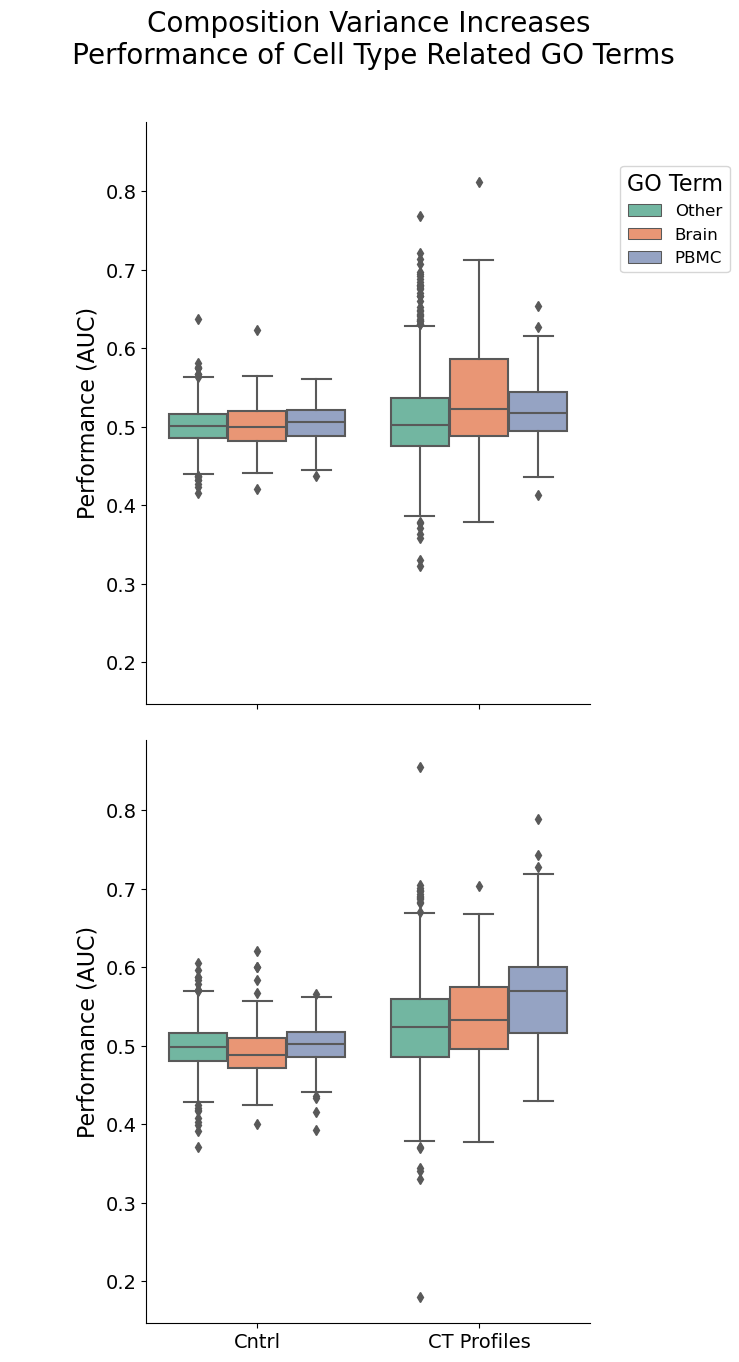

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette
# sns.set_palette('Set2')  # Set the color palette to Dark

# Create a FacetGrid with seaborn
g = sns.FacetGrid(merged, row="tissue", height=7, aspect=0.75)

# Draw a boxplot in each facet
g.map(sns.boxplot, 'exp_type', 'auc', 'meta', palette="Set2")

# Remove facet titles
g.set_titles("")
#

# Set x-axis label with smaller font size
g.set_xlabels("", fontsize=1)

# Set y-axis label with smaller font size
g.set_ylabels("Performance (AUC)", fontsize=16)

# Add a legend with a custom title and font size
legend = plt.legend(title="GO Term", fontsize=12, bbox_to_anchor=(1.05, 2.0), loc='upper left')

# Set the font size of the legend title
legend.get_title().set_fontsize(16)

# Rename the legend labels
legend.get_texts()[0].set_text("Other")
legend.get_texts()[1].set_text("Brain")
legend.get_texts()[2].set_text("PBMC")

# Access each axis and set custom tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(["Cntrl", "CT Profiles"], fontsize=14)
    ax.tick_params(axis='y', labelsize=14)  # Set y-axis tick labels smaller

# Adjust the layout to make room for the title
g.fig.subplots_adjust(top=0.9)

# Add a title to the entire plot
# g.fig.suptitle('Simulated Bulk from Cell Type Profiles', fontsize=16)
g.fig.suptitle('', fontsize=1)
# Add a title to the entire plot
g.fig.suptitle('       Composition Variance Increases \n       Performance of Cell Type Related GO Terms', fontsize=20)


# Save the plot
g.savefig('CTProfileBulkResults.png', dpi = 500)


In [179]:
palette = sns.color_palette("Set2",3)

# Get P-values with Kruskal Wallis - (manu witney signed but with anova more groups)

In [180]:
merged_005 = merged[merged.loc[:,'variance'] == 0.05]

In [181]:
merged_005

,index,variance,exp_type,tissue,auc,id,meta
4,GO:0000045,0.05,cntrl,brain,0.493447,GO:0000045,Neither
5,GO:0000045,0.05,cntrl,pbmc,0.479040,GO:0000045,Neither
6,GO:0000045,0.05,exp,brain,0.549934,GO:0000045,Neither
7,GO:0000045,0.05,exp,pbmc,0.558939,GO:0000045,Neither
12,GO:0000070,0.05,cntrl,brain,0.500129,GO:0000070,Neither
...,...,...,...,...,...,...,...
11159,GO:2001243,0.05,exp,pbmc,0.482432,GO:2001243,Neither
11164,GO:2001244,0.05,cntrl,brain,0.466322,GO:2001244,Neither
11165,GO:2001244,0.05,cntrl,pbmc,0.499054,GO:2001244,Neither
11166,GO:2001244,0.05,exp,brain,0.490557,GO:2001244,Neither


In [182]:
# TODO

import scipy.stats as stats
# Specify the columns for the Kruskal-Wallis test
columns_for_kruskal = ["variance", "exp_type", "id", "meta",'tissue']

# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(*[merged_005[merged_005[col]]['auc'] for col in columns_for_kruskal])


KeyError: "None of [Index([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,\n       ...\n       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],\n      dtype='float64', length=5584)] are in the [columns]"

# Microglia Removal from Brain

In [183]:
import pandas as pd
import os

In [184]:
# micro_rem = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_brain_rm_100/4/EGAD/exp_brain_cpm_pc_micro_removed_cell_type_profiles_.csv/exp_brain_cpm_pc_micro_removed_cell_type_profiles__0.05_EGAD.csv")
# micro_rem = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_brain_rm_100/1/EGAD/cntrl_brain_cpm_pc_micro_removed_cell_type_profiles_.csv/cntrl_brain_cpm_pc_micro_removed_cell_type_profiles__0.05_EGAD.csv")
# micro_rem = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_brain_rm_exh_100/1/EGAD/exp_brain_cpm_pc_exht_removed_cell_type_profiles_.csv/exp_brain_cpm_pc_exht_removed_cell_type_profiles__0.05_EGAD.csv")
micro_rem = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_brain_rm_100/master_melted_df.csv.gz")

In [185]:
melted_results= micro_rem[micro_rem['variance'] == 0.05]

In [186]:
melted_results['exp_type'] = melted_results.organism_part.str.split("_").str.get(0)
melted_results['tissue'] = melted_results.organism_part.str.split("_").str.get(1)

In [205]:
melted_results = melted_results.groupby(['index', 'variance', 'exp_type', 'tissue'])['auc'].mean().reset_index()
melted_results = melted_results.merge(curated_gos, left_on = 'index', right_on='id')


Text(0.5, 1.0, '       Composition Variance Increases \n       Performance of Cell Type Related GO Terms')

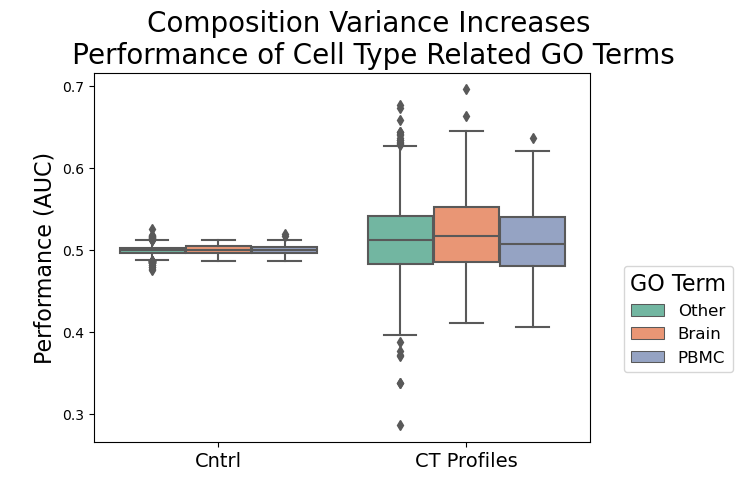

In [225]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1,1)

sns.set_palette('Set2')


g = sns.boxplot(data = melted_results, x = 'exp_type', y = 'auc', hue = 'meta', ax=ax1)


# Set x-axis label with smaller font size
g.set_xlabel("", fontsize=1)
# Set y-axis label with smaller font size
g.set_ylabel("Performance (AUC)", fontsize=16)
# x axis ticks
g.set_xticklabels(labels = ["Cntrl", "CT Profiles"], fontsize=14)
# Add a legend with a custom title and font size
legend = plt.legend(title="GO Term", fontsize=12, bbox_to_anchor=(1.05, 0.5))

# Set the font size of the legend title
legend.get_title().set_fontsize(16)

# Rename the legend labels
legend.get_texts()[0].set_text("Other")
legend.get_texts()[1].set_text("Brain")
legend.get_texts()[2].set_text("PBMC")

# Add a title to the entire plot

# Add a title to the entire plot
plt.title('       Composition Variance Increases \n       Performance of Cell Type Related GO Terms', fontsize=20)

# Comparison with Bulk 

In [16]:
path_to_bulk  = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkEGADPipeline/data/splitOPs1/EGAD/melted_dfs/Brain_split.csv_melted_EGADs.csv.gz"
bulk_df = pd.read_csv(path_to_bulk, index_col=0)

In [17]:
bulk_df_mean = bulk_df.groupby('index')['auc'].mean()
bulk_df_mean.name='bulk_auc'

In [18]:
merged = merged.merge(right = bulk_df_mean, left_on='index', right_index=True)

In [19]:
merged.to_csv("merged_for_homl.csv")

In [20]:
holm_df_merged = holm_df.merge(right = bulk_df_mean, left_on='index', right_index=True)
holm_df_merged = holm_df_merged.merge(curated_gos, left_on='index', right_on='id')

In [21]:
holm_df_merged.to_csv("holm_df.csv")

In [22]:
merged_sub = merged[merged.loc[:,'exp_type'] == 'exp']
# merged_sub = merged_sub[merged_sub.loc[:,'tissue'] == 'brain']
merged

,index,variance,exp_type,tissue,auc,id,meta,bulk_auc
4,GO:0000045,0.05,cntrl,brain,0.493447,GO:0000045,Neither,0.533385
5,GO:0000045,0.05,cntrl,pbmc,0.479040,GO:0000045,Neither,0.533385
6,GO:0000045,0.05,exp,brain,0.549934,GO:0000045,Neither,0.533385
7,GO:0000045,0.05,exp,pbmc,0.558939,GO:0000045,Neither,0.533385
12,GO:0000070,0.05,cntrl,brain,0.500129,GO:0000070,Neither,0.622184
...,...,...,...,...,...,...,...,...
11159,GO:2001243,0.05,exp,pbmc,0.482432,GO:2001243,Neither,0.567128
11164,GO:2001244,0.05,cntrl,brain,0.466322,GO:2001244,Neither,0.649389
11165,GO:2001244,0.05,cntrl,pbmc,0.499054,GO:2001244,Neither,0.649389
11166,GO:2001244,0.05,exp,brain,0.490557,GO:2001244,Neither,0.649389


In [23]:
merged_sub.loc[:,'meta'] = pd.Categorical(merged_sub.loc[:,'meta'], categories=['Neither', 'Brain', 'PBMC'], ordered=True)
merged_sub.loc[:,'tissue'] = pd.Categorical(merged_sub.loc[:,'tissue'], categories=['pbmc','brain'], ordered=True)

In [24]:
for name, df in merged_sub.groupby(['tissue', "meta"], observed=True):
    print(name)

('brain', 'Brain')
('brain', 'Neither')
('brain', 'PBMC')
('pbmc', 'Brain')
('pbmc', 'Neither')
('pbmc', 'PBMC')


In [29]:
merged_sub.head()

,index,variance,exp_type,tissue,auc,id,meta,bulk_auc
6,GO:0000045,0.05,exp,brain,0.549934,GO:0000045,Neither,0.533385
7,GO:0000045,0.05,exp,pbmc,0.558939,GO:0000045,Neither,0.533385
14,GO:0000070,0.05,exp,brain,0.499142,GO:0000070,Neither,0.622184
15,GO:0000070,0.05,exp,pbmc,0.565864,GO:0000070,Neither,0.622184
22,GO:0000077,0.05,exp,brain,0.473964,GO:0000077,Neither,0.532863


0.5879692700484092
brain, Neither, slope 0.2706491771431537, intercept 0.4504239470962126
0.611822820712672
brain, Brain, slope 0.4885691824333567, intercept 0.3501346756167451
0.6575159259804912
brain, PBMC, slope 0.3379308059611317, intercept 0.481146800027317
0.5879692700484092
pbmc, Neither, slope 0.25539961066491806, intercept 0.45405547233743837
0.611822820712672
pbmc, Brain, slope 0.07839197233265492, intercept 0.5698282638146872
0.6575159259804912
pbmc, PBMC, slope 0.4210322192828656, intercept 0.41996351423938355


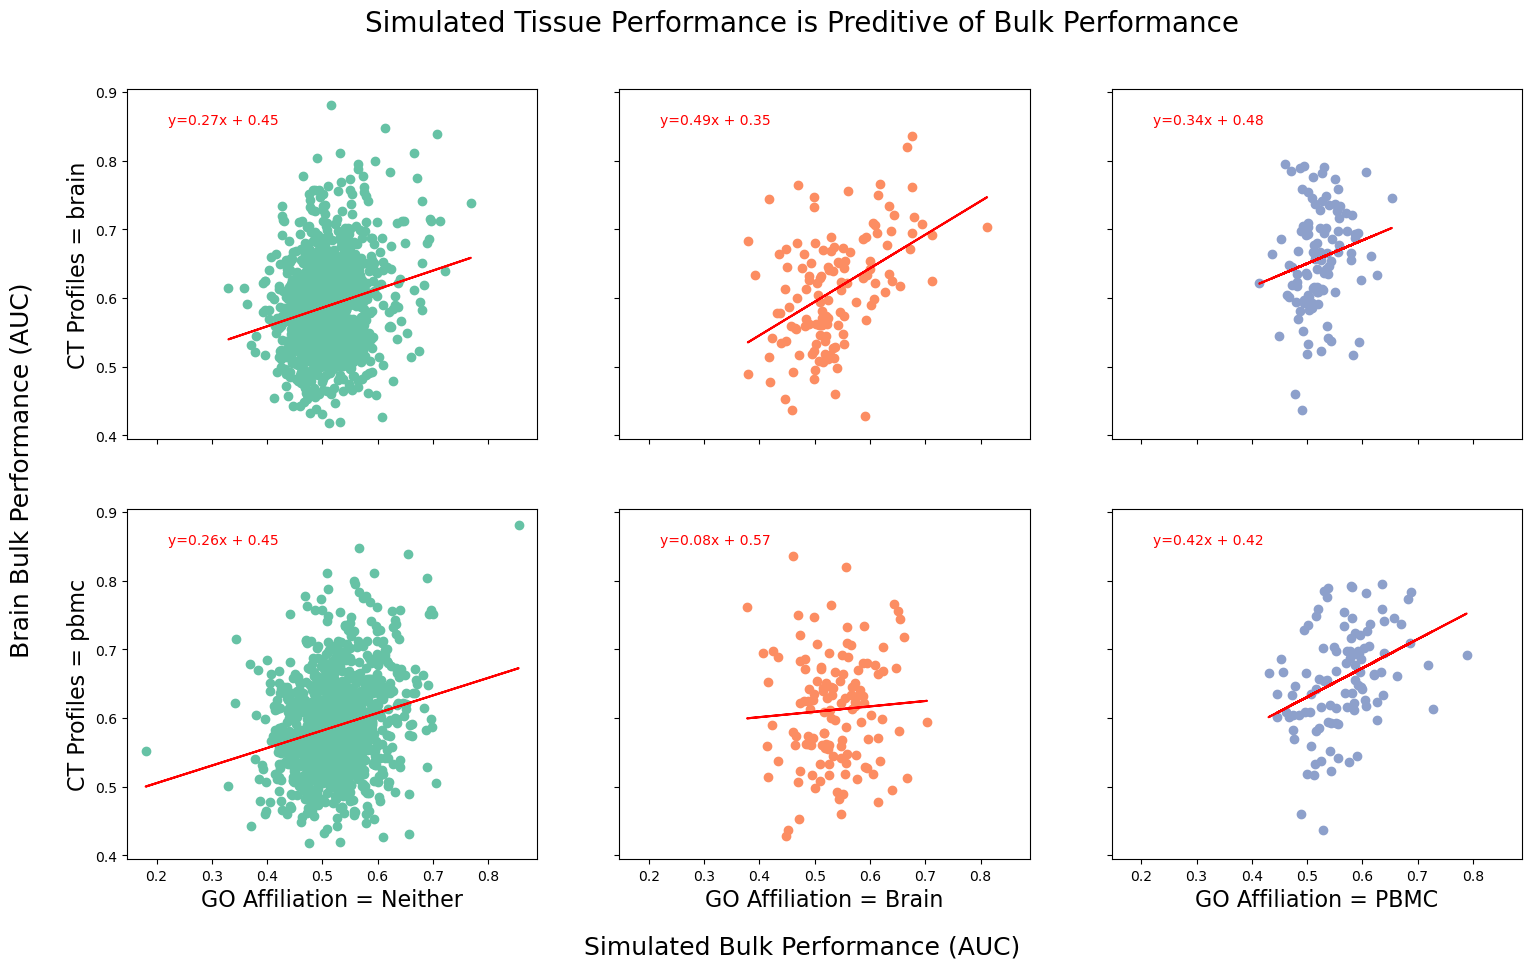

In [42]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

palette = sns.color_palette("Set2",3)
 
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
 
fig.suptitle('Simulated Tissue Performance is Preditive of Bulk Performance', fontsize = 20, y = 0.96)

for row_i, tissue in enumerate(merged.loc[:,'tissue'].unique()):
    
    axes[row_i,0].set_ylabel(f"CT Profiles = {tissue}",  fontsize=16)
    
    for col_i, go in enumerate(merged.loc[:,'meta'].unique()):
        
        ax = axes[row_i,col_i]
        
        color = palette[col_i]
        
        data = merged_sub.loc[(merged_sub.loc[:,'tissue'] == tissue) & (merged_sub.loc[:,'meta'] == go)]
        x = data.loc[:,'auc']
        y = data.loc[:,'bulk_auc']
        print(y.mean())
        slope, intercept, r_value, p_value, _ = linregress(x,y)       
        
        print(f"{tissue}, {go}, slope {slope}, intercept {intercept}") 
        
        # Scatter plot
        ax.scatter(x, y, color = color)

        # Plot line of best fit
        ax.plot(x, slope * x + intercept, color='red')
        
        # Add slope as text
        ax.text(0.1, 0.9, f'y={slope:.2f}x + {intercept:.2f}', color='red', transform=axes[row_i, col_i].transAxes)
        
        # add x axis titles
        
        axes[1,col_i].set_xlabel(f"GO Affiliation = {go}", fontsize=16)

        

axes[0]
        
        

fig.supxlabel("Simulated Bulk Performance (AUC)", fontsize=18)
fig.supylabel("Brain Bulk Performance (AUC)", fontsize=18, x = 0.06)

plt.show()

In [40]:
x = [2,6,2]
y = [3,7,6]

slope, intercept, r_value, p_value, _ = linregress(x,y)       
print(slope)
print(intercept)

0.625
3.2499999999999996


# Exception Proves Rule

Look at high performing GO term in Brian that is PBMC tagged


With brain Data, we get some PBMC performing GO Terms

Why is there performance? The argument is that there is performance for this GO term because it contains genes that are highly expressed in specific Cell Types in our brain data. This is to say that peformance is still driven by cell type specific expression information that is added into our data via coexpression of cell type profiles. 

Furthermore, because microglial cells are also immune cells, we expected them to have some PBMC function. We expect that the genes that are in this high performing PBMC GO term are highly expressed in microglial cells. Then when compV is introduced, coexpression between these genes is induced, thereby resulting in performance. 

We have brain CT Profiles. But we are getting PBMC performance. It must be that the GO terms that are performing have genes that are highly expressed in some CT profiles. This is because again, we are only getting coxpression from CT profiles. So  this must mean two things 1. Those genes are expressed in our CT Profiles, 2. Those genes are coexpressed across our CT Profiles. Coexpression can either be driven by CT marker genes. It will likely be driven by CT Marker genes as opposed inter-cellular coexpression like ribosomal gene expression. This is because we know that when we compV, we get correlation of CT Markers especially. Furthermore, because we are getting PBMC performance, we can maybe guess that we will see lots of microglial expression, which has lots of PBMC overlap


How can I quantify this? Its like I need to show that coexpression decreses within these GO terms as performance goes down, but thats obvious. Maybe I don't need to really quantify it because its like I'm just showing an exception.


In [ ]:
merged_exception = merged[merged.loc[:,'tissue'] =='brain']
merged_exception = merged_exception[merged_exception.loc[:,'exp_type'] =='exp']
merged_exception = merged_exception[merged_exception.loc[:,'meta'] =='PBMC']

In [125]:
merged_exception.sort_values('auc', ascending=False)

,index,variance,exp_type,tissue,auc,id,meta,bulk_auc
3806,GO:0014059,0.05,exp,brain,0.653405,GO:0014059,PBMC,0.746226
8694,GO:0050901,0.05,exp,brain,0.626596,GO:0050901,PBMC,0.632960
598,GO:0001916,0.05,exp,brain,0.615723,GO:0001916,PBMC,0.660990
1958,GO:0006953,0.05,exp,brain,0.606739,GO:0006953,PBMC,0.784070
6358,GO:0042100,0.05,exp,brain,0.598336,GO:0042100,PBMC,0.626544
...,...,...,...,...,...,...,...,...
3942,GO:0016064,0.05,exp,brain,0.459519,GO:0016064,PBMC,0.794827
7942,GO:0048008,0.05,exp,brain,0.452837,GO:0048008,PBMC,0.685396
494,GO:0001818,0.05,exp,brain,0.449918,GO:0001818,PBMC,0.544669
4758,GO:0030316,0.05,exp,brain,0.435718,GO:0030316,PBMC,0.664273


In [126]:
# Selected GO term
exception_go = "GO:0050901" # pbmc good performing
# exception_go = "GO:0042104" # pbmc mid performing
# exception_go = "GO:0071353" # pbmc poor performingb
# exception_go = "GO:0050911" #brain related

In [127]:
exception_auc = merged_exception[merged_exception.loc[:,'index'] == exception_go]['auc'].values[0]

In [128]:
# Load GO annotations to get genes in this gO term
go_annot = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/final/bp_annotations_withGeneData_qc_annotations_no_dependance.csv")
go_annot.head()

,DB_Object_Symbol,GO ID,Aspect,DB Object Name,ensembl_gene_id,hgnc_symbol,uniprotswissprot,entrezgene_id,description
0,IRGM,GO:0000045,P,Immunity-related GTPase family M protein,ENSG00000237693,IRGM,A1A4Y4,345611.0,immunity related GTPase M [Source:HGNC Symbol;...
1,BECN2,GO:0000045,P,Beclin-2,ENSG00000196289,BECN2,A8MW95,441925.0,beclin 2 [Source:HGNC Symbol;Acc:HGNC:38606]
2,AP4M1,GO:0000045,P,AP-4 complex subunit mu-1,ENSG00000221838,AP4M1,NaN,9179.0,adaptor related protein complex 4 subunit mu 1...
3,ATG13,GO:0000045,P,Autophagy-related protein 13,ENSG00000175224,ATG13,NaN,9776.0,autophagy related 13 [Source:HGNC Symbol;Acc:H...
4,ULK1,GO:0000045,P,Serine/threonine-protein kinase ULK1,ENSG00000177169,ULK1,O75385,8408.0,unc-51 like autophagy activating kinase 1 [Sou...


In [129]:
go_annot_exception = go_annot[go_annot.loc[:,"GO ID"]==exception_go]

In [130]:
# Load CT Profiles of Brain and PBMC
brain_cts = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run_feb29/4/CTProfiles/exp_brain_sc_with_metadata_pc_cpm_cell_type_profiles.csv", index_col=0)

In [132]:
brain_cts_subset = brain_cts.loc[:,brain_cts.columns.isin(go_annot_exception.ensembl_gene_id)]

In [133]:
brain_cts_subset.loc["Microglial cells",:].median()

15.820286

In [134]:
brain_cts_subset.head()

,ENSG00000007908,ENSG00000067900,ENSG00000075340,ENSG00000099866,ENSG00000110876,ENSG00000113384,ENSG00000114631,ENSG00000115232,ENSG00000139626,ENSG00000150093,ENSG00000154721,ENSG00000162692,ENSG00000168329,ENSG00000174175,ENSG00000174697,ENSG00000182197,ENSG00000187210,ENSG00000188404,ENSG00000197471
Astrocytes,0.000000,127.68863,1.719076,2.001871,0.000000,47.985355,27.176410,0.000000,2.621660,49.33161,161.434940,0.000000,0.733562,0.635992,0.000000,237.32413,3.970798,1.902364,0.000000
Excitatory neurons,0.103325,111.34364,94.665600,2.155021,0.312395,64.959270,29.367678,13.362238,0.067102,50.35933,20.522642,0.002159,0.423720,0.626466,0.295287,314.33105,15.892694,0.193616,0.024637
Inhibitory neurons,0.068828,102.97272,70.971504,2.389283,0.352114,62.824383,82.004790,0.712594,0.072943,71.43263,64.386720,0.007583,0.947773,0.301086,0.206842,598.69680,2.175813,0.103269,0.036819
Microglial cells,2.860911,274.42250,4.846069,0.000000,37.962520,103.960650,14.580367,27.638273,4.489510,165.64255,194.637400,15.820286,495.323240,0.000000,0.000000,392.05978,38.240910,5.076657,4.308851
Oligodendrocyte precursor cells,0.000000,131.30957,25.462210,2.195644,0.000000,80.289510,44.521830,23.470276,0.000000,69.66154,115.962616,0.000000,2.540672,0.000000,0.000000,259.53320,0.547870,0.000000,2.508701


In [135]:
brain_cts_column = brain_cts_subset.iloc[:,5]

In [136]:
def do_t_test(column):
    lo_p_vals = [] # lsit to hold pvals
    i = 0
    for n in range(len(column)):
        val = column[i]
        others = [x for index, x in enumerate(column) if index != i]
        t_statistic, p_value = ttest_1samp(others, val)
        lo_p_vals.append(p_value)
        i+=1
    return lo_p_vals

lo_col_pvals = []
for col_index in range(brain_cts_subset.shape[1]):
    column = brain_cts_subset.iloc[:,col_index]
    lo_p_vals = do_t_test(column)
    lo_col_pvals.append(lo_p_vals)
    

/tmp/ipykernel_34328/2018713278.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = column[i]


NameError: name 'ttest_1samp' is not defined

In [137]:
df_p_vals = pd.DataFrame(lo_col_pvals, columns = brain_cts_column.index, index = brain_cts_subset.columns)

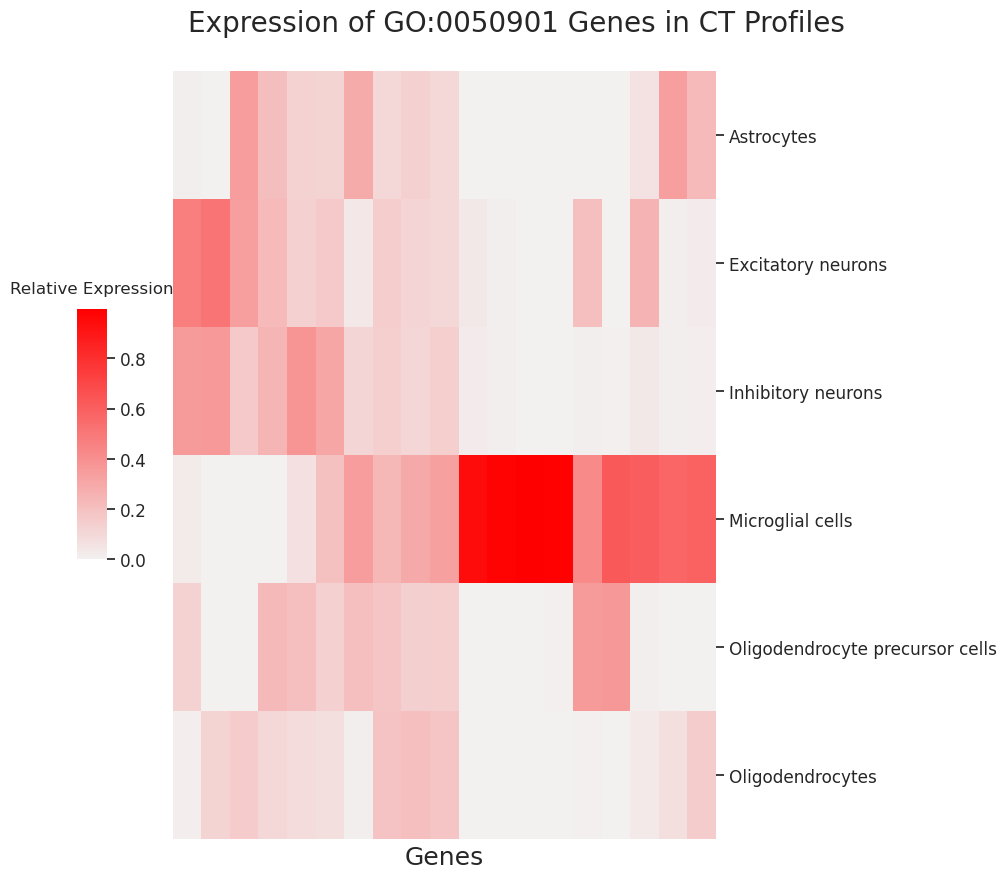

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a custom colormap ranging from red to white
cmap = sns.light_palette("red", as_cmap=True)

# Example data (replace with your data)
# Example data (replace with your data)
# Example data (replace with your data)
# Example data (replace with your data)

# Divide each column by the sum of each column
df_normalized = brain_cts_subset.div(brain_cts_subset.sum())
sns.set(font_scale=1.1)
# Create the clustermap with customizations
cg = sns.clustermap(df_normalized, 
               row_cluster=False,  # Remove row dendrogram
               col_cluster=True,  # Remove column dendrogram
               col_linkage=None,
               xticklabels=False,
               cmap=cmap,
               cbar_pos=(0.06,0.3,0.03,0.25),
               
              )

ax.set_yticklabels(ax.get_xticklabels(), fontsize = 16)
ax = cg.ax_heatmap
ax.set_xlabel("Genes", fontsize = 18)

# Add a legend title to the color bar
cbar_ax = cg.cax
cbar_ax.text(0.5, 1.05, 'Relative Expression', ha='center', va='bottom', fontsize=12)



ax.set_ylabel("")
cg.fig.suptitle(f"Expression of {exception_go} Genes in CT Profiles",y = 0.85, size =20)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

In [625]:
ax

<Axes: >

In [523]:
average_variance = brain_cts_subset.std(axis = 0).mean()
average_variance

36.21972022429552

In [525]:
brain_cts_subset.loc["Microglial cells",:].median()

15.820286

In [568]:
brain_cts_subset

,ENSG00000044574,ENSG00000073111,ENSG00000079999,ENSG00000081059,ENSG00000096384,ENSG00000100219,ENSG00000100316,ENSG00000102879,ENSG00000107485,ENSG00000118520,...,ENSG00000143184,ENSG00000148218,ENSG00000162892,ENSG00000164935,ENSG00000165030,ENSG00000169710,ENSG00000178035,ENSG00000188282,ENSG00000197417,ENSG00000260314
Astrocytes,75.235480,1.081345,12.915553,7.519947,149.59050,6.441315,36.721916,0.615604,0.000000,1.143550,...,0.000000,40.577200,0.000000,0.317424,3.365715,62.738068,9.298972,3.110460,21.650469,1.716356
Excitatory neurons,26.914284,0.391309,7.238582,3.398257,141.08305,11.745027,24.003680,4.562491,0.079481,0.734260,...,0.024410,13.782670,0.014874,0.647667,7.021318,16.194294,4.037005,0.179680,6.151575,1.122353
Inhibitory neurons,47.957912,0.591917,8.288936,2.937467,210.48474,15.575946,26.291512,2.467319,0.059796,0.185759,...,0.063554,15.069627,0.005876,0.135401,8.030437,17.314503,5.767752,0.227405,7.361449,1.775604
Microglial cells,83.814230,0.000000,7.476995,0.000000,181.02240,51.747590,45.724293,9.919946,1.380062,0.000000,...,0.000000,22.247260,0.000000,0.000000,8.410836,9.303408,1.432927,1.520980,21.271751,155.944470
Oligodendrocyte precursor cells,45.200016,0.000000,19.670103,7.572504,104.78358,13.937716,13.120593,3.881261,0.000000,0.000000,...,0.000000,11.745902,0.000000,0.000000,5.426032,16.870636,5.238419,18.842886,4.830112,0.291327
Oligodendrocytes,57.669754,1.116567,25.036251,4.849668,181.14256,11.347609,35.878670,0.470588,0.000000,0.083283,...,0.000000,27.245087,0.000000,0.083501,4.058808,25.609200,6.928959,0.066902,10.645809,0.603544


In [472]:
np.corrcoef(average_variance, exception_auc)

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


array([[nan, nan],
       [nan, nan]])

In [407]:
np.log2(brain_cts_subset+1)

,ENSG00000017427,ENSG00000096996,ENSG00000103490,ENSG00000105639,ENSG00000110944,ENSG00000113302,ENSG00000114455,ENSG00000115457,ENSG00000117090,ENSG00000119927,...,ENSG00000138814,ENSG00000149273,ENSG00000150782,ENSG00000160223,ENSG00000162594,ENSG00000167664,ENSG00000168040,ENSG00000173757,ENSG00000189403,ENSG00000272398
Astrocytes,1.314627,0.878241,0.000000,2.055580,0.000000,0.000000,1.177743,2.204876,0.000000,7.409088,...,9.046983,5.505138,1.105410,0.435415,0.000000,0.000000,1.129857,6.440777,8.608426,1.835243
Excitatory neurons,1.444478,1.070456,0.142486,2.791175,0.413255,0.018904,1.448373,2.807250,0.060390,3.606483,...,10.326696,5.353421,2.639710,0.061207,0.547281,0.360297,1.491646,5.078540,6.357667,0.832585
Inhibitory neurons,7.440687,0.572376,0.226672,2.213191,0.398177,0.017269,0.807135,1.106625,0.096444,3.787252,...,9.123744,5.580561,2.862545,0.042445,0.452682,0.331221,1.677130,6.461415,6.077778,3.226741
Microglial cells,6.274031,3.495211,5.013052,3.499687,0.000000,0.000000,0.000000,4.849360,1.855936,4.864317,...,9.490543,6.693505,7.317406,0.000000,0.000000,3.434140,3.122505,7.103753,7.778180,1.886177
Oligodendrocyte precursor cells,0.703769,0.000000,0.000000,0.000000,0.000000,0.000000,0.786818,1.273423,0.368854,4.000698,...,9.052763,4.971347,1.813860,0.000000,0.000000,0.000000,0.809217,6.697770,7.264462,0.000000
Oligodendrocytes,1.073952,2.217111,0.149021,0.628597,0.506641,0.000000,1.060888,1.301932,0.080784,3.926132,...,7.705060,6.132692,1.270728,0.759298,0.231443,0.175215,1.790001,6.399811,7.722077,0.127332


In [174]:
brain_cts_subset.corr()

,ENSG00000007908,ENSG00000067900,ENSG00000075340,ENSG00000099866,ENSG00000110876,ENSG00000113384,ENSG00000114631,ENSG00000115232,ENSG00000139626,ENSG00000150093,ENSG00000154721,ENSG00000162692,ENSG00000168329,ENSG00000174175,ENSG00000174697,ENSG00000182197,ENSG00000187210,ENSG00000188404,ENSG00000197471
ENSG00000007908,1.000000,0.872620,-0.315065,-0.830266,0.999592,0.738415,-0.409650,0.658005,0.832295,0.932020,0.631713,0.999248,0.999220,-0.520289,-0.334135,0.234161,0.935158,0.911637,0.832368
ENSG00000067900,0.872620,1.000000,-0.616601,-0.988664,0.881751,0.852966,-0.645554,0.505016,0.769955,0.943535,0.451371,0.885734,0.884346,-0.571158,-0.529172,-0.161515,0.752124,0.903257,0.735313
ENSG00000075340,-0.315065,-0.616601,1.000000,0.594701,-0.341129,-0.350571,0.542045,-0.058153,-0.596931,-0.442322,-0.527756,-0.350834,-0.350443,0.368396,0.936003,0.527604,-0.075911,-0.588567,-0.379960
ENSG00000099866,-0.830266,-0.988664,0.594701,1.000000,-0.838363,-0.814422,0.684254,-0.402676,-0.746333,-0.909055,-0.353503,-0.842208,-0.840039,0.471850,0.457465,0.202009,-0.734554,-0.889063,-0.629857
ENSG00000110876,0.999592,0.881751,-0.341129,-0.838363,1.000000,0.743756,-0.416916,0.655671,0.839597,0.937204,0.641918,0.999940,0.999926,-0.531676,-0.359781,0.219645,0.926620,0.918298,0.838290
ENSG00000113384,0.738415,0.852966,-0.350571,-0.814422,0.743756,1.000000,-0.409247,0.692504,0.384466,0.884278,0.195106,0.746237,0.746006,-0.819182,-0.344881,-0.067603,0.616968,0.588711,0.793776
ENSG00000114631,-0.409650,-0.645554,0.542045,0.684254,-0.416916,-0.409247,1.000000,-0.294783,-0.547409,-0.376035,-0.196305,-0.423148,-0.421218,-0.026794,0.401690,0.747038,-0.485088,-0.599125,-0.302709
ENSG00000115232,0.658005,0.505016,-0.058153,-0.402676,0.655671,0.692504,-0.294783,1.000000,0.345416,0.574505,0.475959,0.655816,0.658899,-0.654175,-0.270781,0.040562,0.652647,0.413242,0.898198
ENSG00000139626,0.832295,0.769955,-0.596931,-0.746333,0.839597,0.384466,-0.547409,0.345416,1.000000,0.711366,0.809905,0.842245,0.841830,-0.196668,-0.570663,0.000968,0.752991,0.964743,0.608849
ENSG00000150093,0.932020,0.943535,-0.442322,-0.909055,0.937204,0.884278,-0.376035,0.574505,0.711366,1.000000,0.475910,0.938589,0.937943,-0.700101,-0.414673,0.152287,0.785816,0.853283,0.810229


In [68]:
# Define the degree of polynomial features
poly_degree = 2

# Get the original feature names
feature_names = ['auc']

# Generate polynomial feature names
for degree in range(2, poly_degree + 1):
    feature_names.extend([f'x^{degree}'])

# Get the one-hot encoded feature names
one_hot_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names(['exp_type', 'tissue', 'meta'])

# Combine polynomial feature names and one-hot encoded feature names
feature_names += list(one_hot_feature_names)
feature_names = ['Intercept'] + feature_names

# Access the coefficients
coefficients = pipeline.named_steps['model'].coef_

# Print coefficients with corresponding feature labels
for feature, coef in zip(feature_names, coefficients):
    print(feature, ':', coef)


AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

In [56]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 PolynomialFeatures(include_bias=False,
                                                    interaction_only=True),
                                 ['x']),
                                ('cat', OneHotEncoder(),
                                 ['exp_type', 'tissue', 'meta'])])

# NEXT

If i get ct profiles, there is no difference in between one cell. All excititory neurons are the same.

For functions that are mostly ubiquitous. I expect to see very little performance, because its likely that the genes that do these ubiquitous processes are always on, anmd likely just the same

But for functions that are CT specific. I'm pretty sure I expect that if I add a bunch of those CT, then I add a bunch of those CT Markers, and then samples will strongly correlate that have those CT Markers

# Get GO Terms affiliated with Brain

In [36]:
# Load GO term cell type affiliation data
path_to_curated_gos = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/bp_curated_annotations.tsv"
curated_gos = pd.read_csv(path_to_curated_gos, sep = "\t")
go_annot = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/processing/bp_annotations_withGeneData_qc_annotations.csv")

In [37]:
# First get a list of all of the GOs related to brains
lo_brain_related_gos = curated_gos[curated_gos.loc[:,'BrainAffiliated'] == "T"].id

In [38]:
# Now get all of the genes in these brain GO terms
go_annot_brain = go_annot[go_annot.loc[:,"GO ID"].isin(lo_brain_related_gos)]
lo_brain_related_genes = go_annot_brain.ensembl_gene_id.unique()

In [39]:
# Load the experimental or control simulated bulk sample
import pandas as pd
con_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run2/1/simulations/0.05/cntrl_brain_sc_with_metadata_pc_cell_type_profiles.csv/cntrl_brain_sc_with_metadata_pc_cell_type_profiles_.csv.gz"
exp_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run2/1/simulations/0.05/exp_brain_sc_with_metadata_pc_cell_type_profiles.csv/exp_brain_sc_with_metadata_pc_cell_type_profiles_.csv.gz"
sim_bulk = pd.read_csv(exp_path, index_col=0)

In [40]:
# get correlations
sim_bulk_corr = sim_bulk.T.corr()

# Make Complex Heatmap


In [41]:
import os,sys
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
# plt.rcParams['figure.dpi'] = 100
# plt.rcParams['savefig.dpi']=300
# plt.rcParams['font.family']='sans serif' #please remove this line if font is not installed
# plt.rcParams['font.sans-serif']='Arial' # please remove this line if Arial font is not installed
# plt.rcParams['pdf.fonttype']=42
# sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap/"))
import PyComplexHeatmap as pch
import pandas as pd

In [42]:
# First, make a df of the annotations that I need.
df_annotations = pd.DataFrame(index=sim_bulk_corr.index, data={"brain": sim_bulk_corr.index.isin(lo_brain_related_genes)})
df_annotations['brain'] = df_annotations['brain'].replace({True: 'T', False: 'F'})
df_annotations = df_annotations.sort_values('brain', ascending=False)

In [43]:
df_annotations

,brain
ENSG00000104375,T
ENSG00000198026,T
ENSG00000182957,T
ENSG00000182963,T
ENSG00000198049,T
...,...
ENSG00000134109,F
ENSG00000134146,F
ENSG00000134152,F
ENSG00000134153,F


AttributeError: QuadMesh.set() got an unexpected keyword argument 'method'

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

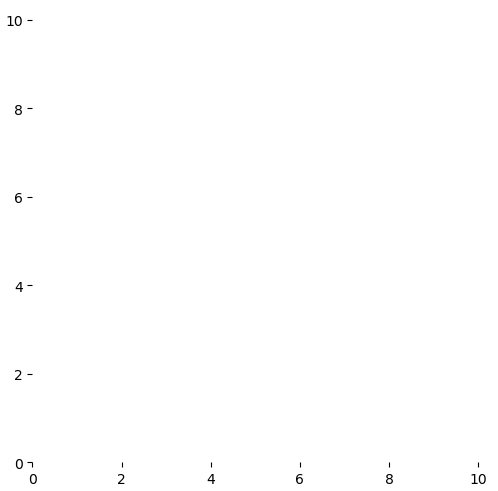

In [133]:
plt.clf()
plt.figure(figsize=(6, 6))

cm = pch.ClusterMapPlotter(data=sim_bulk_corr.iloc[0:10,0:10],
                           top_annotation = col_ha,
                           right_annotation = row_ha,
                            col_cluster=True,
                            row_cluster=True, # cluster rows and dols
                            label='Correlation', # Legend Name
                            # row_dendrogram=True,
                            show_rownames=False,show_colnames=False, # Do not show row or col names
                            cmap='RdBu_r', # set colors
                            verbose=0,
                            legend_gap = 5# distance legend
                            #xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'} # rotate x axis marks
                            )

plt.savefig("example0.png", bbox_inches='tight')
plt.show()


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

Starting plotting HeatmapAnnotations


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

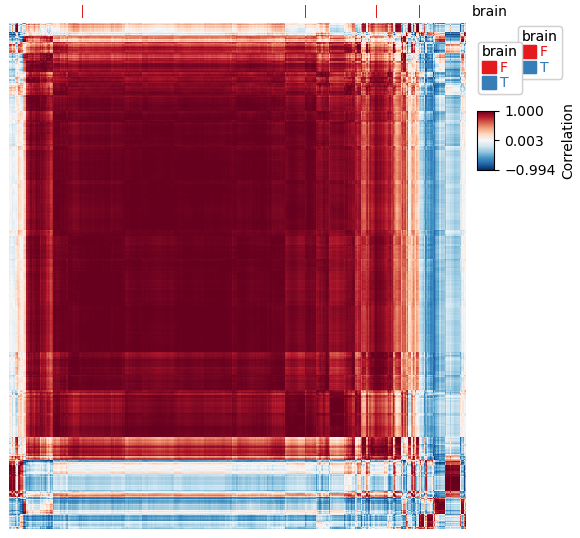

In [139]:
import fastcluster

# custom column linkage
linkage = fastcluster.linkage(sim_bulk_corr.iloc[0:1000,0:1000], method='weighted', metric='canberra')

plt.clf()
plt.figure(figsize=(6, 6))

cm = pch.ClusterMapPlotter(data=sim_bulk_corr.iloc[0:1000,0:1000],
                           top_annotation = col_ha,
                            col_cluster=True,
                            row_cluster=True, # cluster rows and dols
                            label='Correlation', # Legend Name
                            # row_dendrogram=True,
                            show_rownames=False,show_colnames=False, # Do not show row or col names
                            cmap='RdBu_r', # set colors
                            verbose=0,
                            legend_gap = 5, # distance legend
                            #xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'} # rotate x axis marks
                            col_dendrogram_kws=dict(linkage=linkage)
                            )

plt.savefig("example0.png", bbox_inches='tight')
plt.show()


In [17]:
import pandas as pd
con_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run2/1/simulations/0.05/cntrl_brain_sc_with_metadata_pc_cell_type_profiles.csv/cntrl_brain_sc_with_metadata_pc_cell_type_profiles_.csv.gz"
exp_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run2/1/simulations/0.05/exp_brain_sc_with_metadata_pc_cell_type_profiles.csv/exp_brain_sc_with_metadata_pc_cell_type_profiles_.csv.gz"
df = pd.read_csv(exp_path, index_col=0)

# Load GO term cell type affiliation data
path_to_curated_gos = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/bp_curated_annotations.tsv"
curated_gos = pd.read_csv(path_to_curated_gos, sep = "\t")
# /space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run2/1/simulations/0.05/cntrl_brain_sc_with_metadata_pc_cell_type_profiles.csv/cntrl_brain_sc_with_metadata_pc_cell_type_profiles_.csv.gz

In [7]:
df_corr = df.T.corr()

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/PyComplexHeatmap/clustermap.py:850: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/PyComplexHeatmap/clustermap.py:850: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic fam

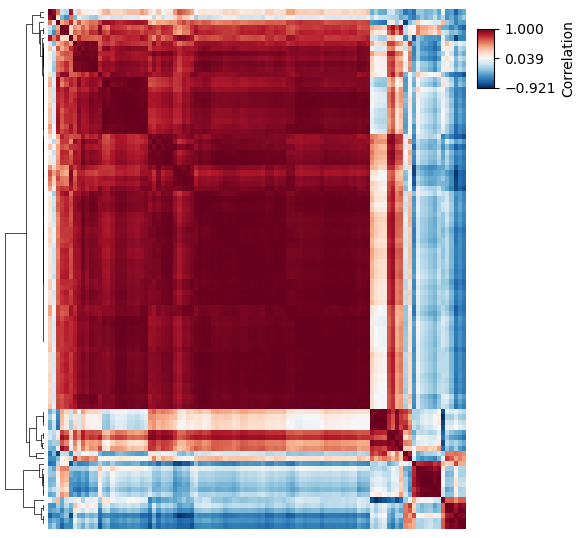

In [39]:
plt.figure(figsize=(6, 6))
cm = pch.ClusterMapPlotter(data=df_corr.iloc[0:100,0:100],
                            col_cluster=True,row_cluster=True, # cluster rows and dols
                            label='Correlation', # Legend Name
                            row_dendrogram=True,
                            show_rownames=False,show_colnames=False, # Do not show row or col names
                            cmap='RdBu_r', # set colors
                            verbose=0,
                            legend_gap = 10 # distance legend
                            #xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'} # rotate x axis marks
                            )

plt.savefig("example0.pdf", bbox_inches='tight')


In [8]:
import os,sys
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['font.family']='sans serif' #please remove this line if font is not installed
plt.rcParams['font.sans-serif']='Arial' # please remove this line if Arial font is not installed
plt.rcParams['pdf.fonttype']=42
# sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap/"))
import PyComplexHeatmap as pch
print(pch.__version__)

1.6.6


In [9]:
#Generate example dataset (random)
df = pd.DataFrame(['GroupA'] * 5 + ['GroupB'] * 5, columns=['AB'])
df['CD'] = ['C'] * 3 + ['D'] * 3 + ['G'] * 4
df['EF'] = ['E'] * 6 + ['F'] * 2 + ['H'] * 2
df['F'] = np.random.normal(0, 1, 10)
df.index = ['sample' + str(i) for i in range(1, df.shape[0] + 1)]
df.head()



,AB,CD,EF,F
sample1,GroupA,C,E,0.819864
sample2,GroupA,C,E,-1.936463
sample3,GroupA,C,E,0.654718
sample4,GroupA,D,E,0.033979
sample5,GroupA,D,E,0.164387


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

Starting plotting HeatmapAnnotations


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

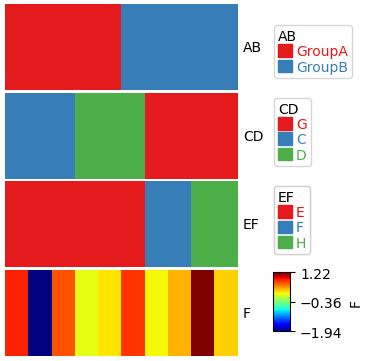

In [10]:
plt.figure(figsize=(3, 4))
col_ha = pch.HeatmapAnnotation(df=df,plot=True,legend=True,legend_gap=5,hgap=0.5,axis=1)
plt.show()

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

Starting plotting HeatmapAnnotations


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

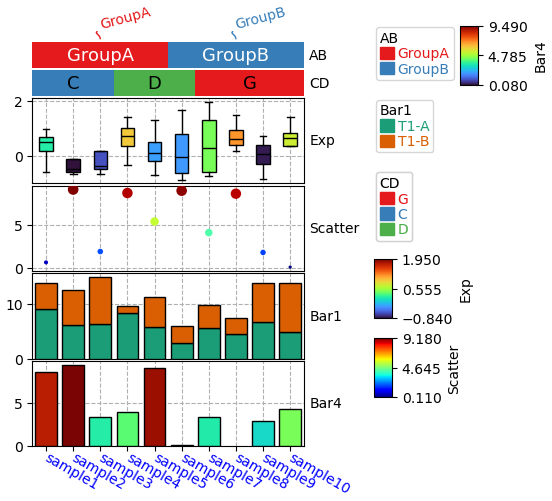

In [11]:
df_box = pd.DataFrame(np.random.randn(10, 4), columns=['Gene' + str(i) for i in range(1, 5)])
df_box.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar = pd.DataFrame(np.random.uniform(0, 10, (10, 2)), columns=['TMB1', 'TMB2'])
df_bar.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_scatter = pd.DataFrame(np.random.uniform(0, 10, 10), columns=['Scatter'])
df_scatter.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar1 = pd.DataFrame(np.random.uniform(0, 10, (10, 2)), columns=['T1-A', 'T1-B'])
df_bar1.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar4 = pd.DataFrame(np.random.uniform(0, 10, (10, 1)), columns=['T4'])
df_bar4.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar4.iloc[7,0]=np.nan

plt.figure(figsize=(3.5, 5))
col_ha = pch.HeatmapAnnotation(label=pch.anno_label(df.AB, merge=True,rotation=15),
                            AB=pch.anno_simple(df.AB,add_text=True,legend=True), axis=1,
                            CD=pch.anno_simple(df.CD, add_text=True,legend=True,text_kws={'color':'black'}),
                            Exp=pch.anno_boxplot(df_box, cmap='turbo',legend=True),
                            Scatter=pch.anno_scatterplot(df_scatter),
                           Bar1=pch.anno_barplot(df_bar1,legend=True,cmap='Dark2'),
                           Bar4=pch.anno_barplot(df_bar4,legend=True,cmap='turbo'),
                           plot=True,legend=True,legend_gap=5,hgap=0.5)
col_ha.show_ticklabels(df.index.tolist(),fontdict={'color':'blue'},rotation=-30)
plt.show()



findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

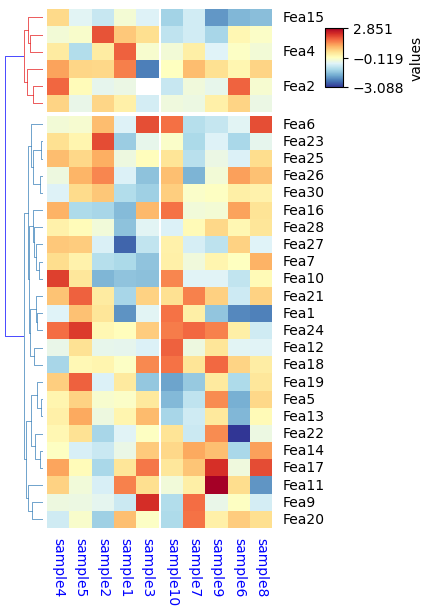

In [12]:
df_heatmap = pd.DataFrame(np.random.randn(30, 10), columns=['sample' + str(i) for i in range(1, 11)])
df_heatmap.index = ["Fea" + str(i) for i in range(1, df_heatmap.shape[0] + 1)]
df_heatmap.iloc[1, 2] = np.nan

plt.figure(figsize=(3.5, 6))
cm = pch.ClusterMapPlotter(data=df_heatmap,
                       col_cluster=True,row_cluster=True,
                       col_split=df.AB,row_split=2,
                       col_split_gap=0.5,row_split_gap=0.8,
                       label='values',row_dendrogram=True,
                       show_rownames=True,show_colnames=True,
                       row_names_side='right',
                       tree_kws={'row_cmap': 'Set1','colors':'blue'},verbose=0,legend_gap=5,
                       cmap='RdYlBu_r',xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'})
plt.savefig("example0.pdf", bbox_inches='tight')
plt.show()

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

Starting plotting HeatmapAnnotations


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

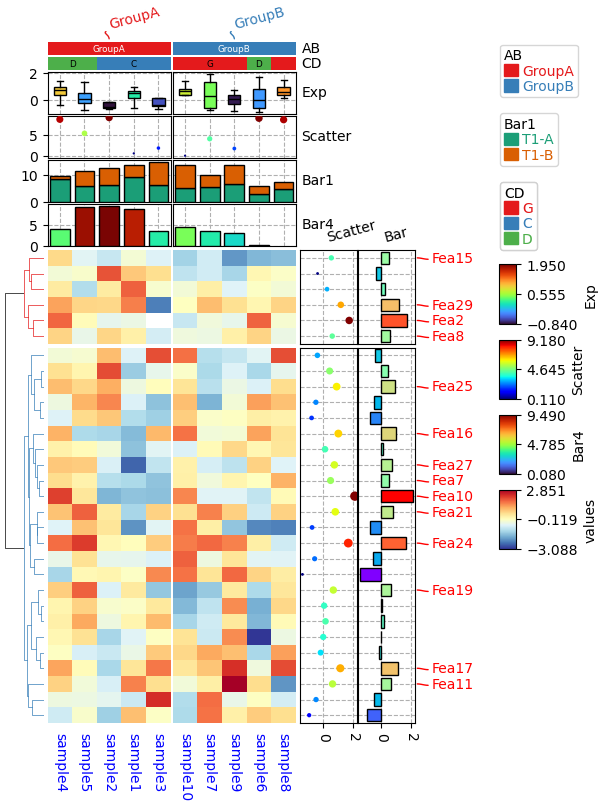

In [13]:
df_rows = df_heatmap.apply(lambda x:x.name if x.sample4 > 0.5 else None,axis=1)
df_rows=df_rows.to_frame(name='Selected')
df_rows['XY']=df_rows.index.to_series().apply(lambda x:'A' if int(x.replace('Fea',''))>=15 else 'B')

col_ha = pch.HeatmapAnnotation(label=pch.anno_label(df.AB, merge=True,rotation=15),
                            AB=pch.anno_simple(df.AB,add_text=True,legend=True), axis=1,
                            CD=pch.anno_simple(df.CD, add_text=True,legend=True,text_kws={'color':'black'}),
                            Exp=pch.anno_boxplot(df_box, cmap='turbo',legend=True),
                            Scatter=pch.anno_scatterplot(df_scatter),
                           Bar1=pch.anno_barplot(df_bar1,legend=True,cmap='Dark2'),
                           Bar4=pch.anno_barplot(df_bar4,legend=True,cmap='turbo'),
                           legend=True,legend_gap=5,hgap=0.5)

row_ha = pch.HeatmapAnnotation(
                           Scatter=pch.anno_scatterplot(df_heatmap.sample4.apply(lambda x:round(x,2)),
                                            height=15,cmap='jet',legend=False),
                           Bar=pch.anno_barplot(df_heatmap.sample4.apply(lambda x:round(x,2)),
                                            height=15,cmap='rainbow',legend=False),
                           selected=pch.anno_label(df_rows,colors='red',relpos=(-0.05,0.4)),
                           label_kws={'rotation':15,'horizontalalignment':'left','verticalalignment':'bottom'},
                            axis=0,verbose=0)

plt.figure(figsize=(5.5, 8))
cm = pch.ClusterMapPlotter(data=df_heatmap, top_annotation=col_ha,right_annotation=row_ha,
                       col_cluster=True,row_cluster=True,
                       col_split=df.AB,row_split=2,
                       col_split_gap=0.5,row_split_gap=0.8,
                       label='values',row_dendrogram=True,
                       show_rownames=False,show_colnames=True,
                       tree_kws={'row_cmap': 'Set1'},verbose=0,legend_gap=5,
                       cmap='RdYlBu_r',xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'})
plt.savefig("example0.pdf", bbox_inches='tight')
plt.show()

In [40]:
df_rows

,Selected,XY
Fea1,None,B
Fea2,Fea2,B
Fea3,None,B
Fea4,None,B
Fea5,None,B
Fea6,None,B
Fea7,Fea7,B
Fea8,Fea8,B
Fea9,None,B
Fea10,Fea10,B


In [44]:
plt.figure(figsize=(3, 4))
col_ha = pch.HeatmapAnnotation(label=pch.anno_label(df.AB, merge=True,rotation=15),
                            AB=pch.anno_simple(df.AB,add_text=True,legend=True), axis=1,
                            CD=pch.anno_simple(df.CD, add_text=True,legend=True,text_kws={'color':'black'}),
                            Exp=pch.anno_boxplot(df_box, cmap='turbo',legend=True),
                            Scatter=pch.anno_scatterplot(df_scatter),
                           Bar1=pch.anno_barplot(df_bar1,legend=True,cmap='Dark2'),
                           Bar4=pch.anno_barplot(df_bar4,legend=True,cmap='turbo'),
                           legend=True,legend_gap=5,hgap=0.5,plot=True)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'AB'

<Figure size 300x400 with 0 Axes>

# Bullk Sim Samples

In [ ]:
test = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulations/bootdev_feb20/1/simulated_bulk_datasets/brain_sc_with_metadata_cpm_pc/var_0.05_brain_sc_with_metadata_cpm_pc_simulated_bulk_samples.csv.gz", index_col = 0)
test.head()

In [ ]:
test_corr = test.T.corr()

In [ ]:
go_annot = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/processing/bp_annotations_withGeneData_qc_annotations.csv")

In [ ]:
brain_gos = curated_gos[curated_gos.loc[:,'BrainAffiliated'] =="T"]

In [ ]:
lo_brain_gos = brain_gos.id
lo_brain_gos

In [ ]:
test_go_term = "GO:0006836"
go_genes = go_annot[go_annot.loc[:,'GO ID'] == test_go_term].ensembl_gene_id

In [ ]:
go_term_gene_corrs = test_corr.iloc[test_corr.index.isin(go_genes), test_corr.index.isin(go_genes)]
go_term_gene_corrs


In [ ]:
go_term_gene_corrs.mean().mean()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt# Assuming you have a 2D dataset, for example, a correlation matrix

# Create a heatmap
sns.set(style="white")  # Optional: Set the background style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the heatmap using Seaborn's heatmap function
heatmap = sns.clustermap(go_term_gene_corrs, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Remove x-axis and y-axis tick marks
heatmap.ax_heatmap.set_xticks([])
heatmap.ax_heatmap.set_yticks([])
plt.title("Heatmap Example")

# Show the plot
plt.show()


In [ ]:
non_go_term_gene_corrs = test_corr.iloc[~test_corr.index.isin(go_genes), ~test_corr.index.isin(go_genes)]

In [ ]:
non_go_term_gene_corrs.mean()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt# Assuming you have a 2D dataset, for example, a correlation matrix

# Create a heatmap
sns.set(style="white")  # Optional: Set the background style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the heatmap using Seaborn's heatmap function
heatmap = sns.heatmap(non_go_term_gene_corrs, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Remove x-axis and y-axis tick marks
heatmap.ax_heatmap.set_xticks([])
heatmap.ax_heatmap.set_yticks([])
plt.title("Heatmap Example")

# Show the plot
plt.savefig('non_go_terms_corr_CELL_Bulk.png')


# CT Simulated Bulk

In [ ]:
df_corr_genes_in_go =  df_corr.iloc[df_corr.index.isin(go_genes),df_corr.index.isin(go_genes)]

In [ ]:
df_corr_genes_in_go.mean().mean()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt# Assuming you have a 2D dataset, for example, a correlation matrix

# Create a heatmap
sns.set(style="white")  # Optional: Set the background style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the heatmap using Seaborn's heatmap function
heatmap = sns.clustermap(df_corr_genes_in_go, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Remove x-axis and y-axis tick marks
heatmap.ax_heatmap.set_xticks([])
heatmap.ax_heatmap.set_yticks([])
plt.title("Heatmap Example")

# Show the plot
plt.show()


In [ ]:
df_corr_genes_not_in_go =  df_corr.iloc[~df_corr.index.isin(go_genes),~df_corr.index.isin(go_genes)]
df_corr_genes_not_in_go

In [ ]:
df_corr_genes_not_in_go.mean().mean()

In [16]:
df_corr_genes_not_in_go.iloc[0:100,0:100]

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000005379,ENSG00000005381,ENSG00000005421,ENSG00000005436,ENSG00000005448,ENSG00000005469,ENSG00000005471,ENSG00000005483,ENSG00000005486,ENSG00000005513
ENSG00000000003,1.000000,-0.217412,-0.203734,-0.200691,-0.440572,-0.398527,-0.339447,-0.267607,-0.345377,-0.461779,...,0.062697,0.134909,0.979946,-0.203134,-0.201628,-0.140034,-0.339870,-0.283203,-0.171366,-0.362219
ENSG00000000005,-0.217412,1.000000,0.977173,0.964815,0.912685,-0.214603,-0.239157,0.990463,0.899308,0.944614,...,0.947227,0.924716,-0.400285,0.965133,0.963356,0.887079,0.657274,0.969307,0.998423,-0.161298
ENSG00000000419,-0.203734,0.977173,1.000000,0.998274,0.918206,-0.229182,-0.270407,0.949391,0.891392,0.959593,...,0.961503,0.940605,-0.382993,0.997464,0.998219,0.963235,0.505771,0.996220,0.980216,-0.019693
ENSG00000000457,-0.200691,0.964815,0.998274,1.000000,0.922377,-0.204088,-0.248761,0.930130,0.871154,0.954578,...,0.959000,0.938001,-0.379354,0.996339,0.999897,0.976662,0.477364,0.995324,0.968124,-0.003659
ENSG00000000460,-0.440572,0.912685,0.918206,0.922377,1.000000,0.161861,0.117449,0.877929,0.748301,0.930798,...,0.831291,0.788927,-0.608227,0.897341,0.918517,0.879793,0.668834,0.931640,0.895196,-0.134671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000005469,-0.140034,0.887079,0.963235,0.976662,0.879793,-0.181553,-0.237333,0.830148,0.788080,0.901004,...,0.929967,0.913452,-0.309756,0.967895,0.977271,1.000000,0.312538,0.960881,0.895239,0.089819
ENSG00000005471,-0.339870,0.657274,0.505771,0.477364,0.668834,0.300770,0.329966,0.682229,0.437651,0.532350,...,0.483597,0.447449,-0.466704,0.451219,0.468084,0.312538,1.000000,0.499943,0.625886,-0.659886
ENSG00000005483,-0.283203,0.969307,0.996220,0.995324,0.931640,-0.199792,-0.247330,0.945148,0.902588,0.978743,...,0.934143,0.907906,-0.455387,0.995457,0.995656,0.960881,0.499943,1.000000,0.969139,0.036088
ENSG00000005486,-0.171366,0.998423,0.980216,0.968124,0.895196,-0.257651,-0.281461,0.986995,0.901672,0.936136,...,0.960591,0.941796,-0.355530,0.970270,0.967037,0.895239,0.625886,0.969139,1.000000,-0.152576


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt# Assuming you have a 2D dataset, for example, a correlation matrix

# Create a heatmap
sns.set(style="white")  # Optional: Set the background style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the heatmap using Seaborn's heatmap function
heatmap = sns.clustermap(df_corr_genes_not_in_go, annot=False, cmap="coolwarm")

heatmap.ax_row_dendrogram.set_visible(False)
heatmap.ax_col_dendrogram.set_visible(False)


# Remove x-axis and y-axis tick marks
heatmap.ax_heatmap.set_xticks([])
heatmap.ax_heatmap.set_yticks([])

plt.title("Heatmap Example")
# Show the plot
plt.savefig('df_corr_genes_not_in_go_CTbulk.png')
plt.close()

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 800x600 with 0 Axes>

In [ ]:
results_for_test_go_term = melted_results[melted_results.loc[:,'index'] == test_go_term]
results_for_test_go_term

In [ ]:
results_for_test_go_term.groupby(['variance', 'exp_type', 'Tissue'])['auc'].mean() # Its pretty weird that the performance is decreasing beteen cntrl and exp.